# FSE Challenge
Notebook created by Sophie Wang
<br><br>
<b>Question</b>: Will a forest fire occur in a given region on a specific day?

## Data Exploration and Preprocessing

In [1]:
# import data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read csv file into dataframe and display first 5 rows
df = pd.read_csv('n240.csv')
df.head()

,region_id,date,temperature,humidity,wind_speed,rainfall,vegetation_type,drough_index,previous_fire,fire_occurrence
0,1.0,2023-01-01 00:00:00,29.773312,84.710759,4.665236,0.847981,Shrubland,0.706012,0.0,0.0
1,1.0,2023-01-02 00:00:00,19.267481,70.835021,16.753346,2.925033,Shrubland,0.667292,0.0,0.0
2,1.0,2023-01-03 00:00:00,32.894305,75.852071,10.829271,3.858680,Shrubland,0.625556,0.0,0.0
3,1.0,2023-01-04 00:00:00,26.960311,80.894930,13.943569,0.717945,Shrubland,0.661796,0.0,1.0
4,1.0,2023-01-05 00:00:00,27.075079,65.085132,17.118529,1.162567,Shrubland,0.684880,1.0,1.0


In [3]:
# display basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region_id        17860 non-null  float64
 1   date             17901 non-null  object 
 2   temperature      17886 non-null  float64
 3   humidity         17868 non-null  float64
 4   wind_speed       17875 non-null  float64
 5   rainfall         17902 non-null  float64
 6   vegetation_type  17917 non-null  object 
 7   drough_index     17883 non-null  float64
 8   previous_fire    17891 non-null  float64
 9   fire_occurrence  17867 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.4+ MB


In [4]:
# display descriptive statistics of the dataframe
df.describe()

,region_id,temperature,humidity,wind_speed,rainfall,drough_index,previous_fire,fire_occurrence
count,17860.000000,17886.000000,17868.000000,17875.000000,17902.000000,17883.000000,17891.000000,17867.000000
mean,25.517917,24.966290,50.017210,19.926352,6.074853,0.531685,0.397630,0.397325
std,14.442441,8.925320,22.332482,11.998242,10.179374,0.121276,0.489422,0.489358
min,1.000000,-3.318065,-0.979070,-7.498165,0.000000,0.003009,0.000000,0.000000
25%,13.000000,18.230743,30.041897,9.806080,0.000000,0.485288,0.000000,0.000000
50%,26.000000,25.015521,49.982110,19.867257,1.633977,0.558158,0.000000,0.000000
75%,38.000000,31.746203,70.041239,30.028809,7.899238,0.609200,1.000000,1.000000
max,50.000000,53.672885,101.474501,48.199633,114.091525,0.769467,1.000000,1.000000


### Initial Insights
1. Non-null counts are different for each column => some rows contains null values => **drop rows with null values to improve data quality and reliability**
2. Exact date & time too specific to work with => **turn date column into month column for relevancy**
3. Humidity contains values <0% and >100% => perhaps error? => **print and drop any values outside of 0-100**
4. Wind speed contains values <0 => perhaps error? => **print and drop any values <0**
5. Vegetation type is non-numeric => **convert vegetation_type values into int categories for encoding**

In [5]:
# 1. drop rows with any missing values
df.dropna(axis=0, inplace=True)

In [6]:
# 2a. convert 'date' column to datetime format and extract month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df.drop(columns=['date'], inplace=True)

# confirm month values were extracted correctly
df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

<Axes: xlabel='month', ylabel='count'>

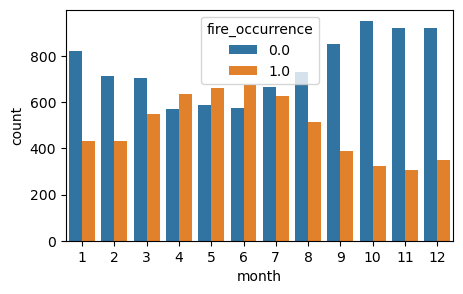

In [7]:
# 2b. graph month vs fire occurrence to determine if there is a seasonal pattern
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='month', hue='fire_occurrence')


    month        0.0        1.0
0       1  65.498008  34.501992
1       2  62.249346  37.750654
2       3  56.274980  43.725020
3       4  47.254576  52.745424
4       5  46.960000  53.040000
5       6  45.950281  54.049719
6       7  51.393189  48.606811
7       8  58.681672  41.318328
8       9  68.573731  31.426269
9      10  74.725275  25.274725
10     11  74.979625  25.020375
11     12  72.533544  27.466456


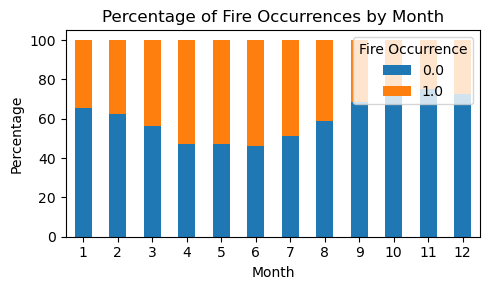

In [8]:
# 2c. calculate the percentage of fire occurrences by month
monthly_fire_counts = df.groupby('month')['fire_occurrence'].value_counts(normalize=True).unstack()
monthly_fire_counts = monthly_fire_counts.fillna(0) * 100
monthly_fire_counts = monthly_fire_counts.reset_index()
monthly_fire_counts.columns.name = None
# display the percentage of fire occurrences by month
print(monthly_fire_counts)
# graph the percentage of fire occurrences by month
monthly_fire_counts.plot(x='month', kind='bar', stacked=True, figsize=(5, 3))
plt.title('Percentage of Fire Occurrences by Month')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Fire Occurrence', loc='upper right')
plt.tight_layout()
plt.show()

In [9]:
# 2d. separate months into fire seasons
def get_fire_season(month):
    if month in [4, 5, 6]:
        return 4 # peak
    elif month in [3, 7, 8]:
        return 3 # high
    elif month in [1, 2, 9]:
        return 2 # moderate
    else:  # [10, 11, 12]
        return 1 # low

df['fire_season'] = df['month'].apply(get_fire_season)
df.drop(columns=['month'], inplace=True)

# confirm fire seasons were assigned correctly
df['fire_season'].unique()

array([2, 3, 4, 1])

In [10]:
# 3a. display out of bounds humidity values
def print_humidity_outliers(df):
    high_humidity = df[df['humidity'] > 100]
    low_humidity = df[df['humidity'] < 0]
    print("High Humidity Values:\n", high_humidity)
    print("Low Humidity Values:\n", low_humidity)

print_humidity_outliers(df)

High Humidity Values:
        region_id  temperature    humidity  wind_speed  rainfall  \
4756        14.0    26.063766  100.849602   15.549376  2.673016   
6563        18.0    32.996944  101.135177   21.782599  2.984522   
17512       48.0    33.881392  101.474501    3.285977  6.057767   
18241       50.0    32.302131  100.553105    5.882877  2.528726   

      vegetation_type  drough_index  previous_fire  fire_occurrence  \
4756     Mixed Forest      0.564838            0.0              0.0   
6563     Mixed Forest      0.530915            0.0              0.0   
17512       Shrubland      0.483584            1.0              0.0   
18241       Grassland      0.574764            0.0              0.0   

       fire_season  
4756             2  
6563             1  
17512            1  
18241            1  
Low Humidity Values:
       region_id  temperature  humidity  wind_speed  rainfall  \
1665        5.0     7.311166  -0.97907   25.013560  0.991921   
7845       22.0    31.672094  

In [11]:
# 3b. drop rows with out of bounds humidity values
df = df[(df['humidity'] >= 0) & (df['humidity'] <= 100)]
# confirm that out of bounds humidity values were dropped
print_humidity_outliers(df)

High Humidity Values:
 Empty DataFrame
Columns: [region_id, temperature, humidity, wind_speed, rainfall, vegetation_type, drough_index, previous_fire, fire_occurrence, fire_season]
Index: []
Low Humidity Values:
 Empty DataFrame
Columns: [region_id, temperature, humidity, wind_speed, rainfall, vegetation_type, drough_index, previous_fire, fire_occurrence, fire_season]
Index: []


In [12]:
# 4a. display out of bounds wind speed values
def print_wind_speed_outliers(df):
    low_wind_speed = df[df['wind_speed'] < 0]
    print("Low Wind Speed Values:\n", low_wind_speed)

print_wind_speed_outliers(df)

Low Wind Speed Values:
        region_id  temperature   humidity  wind_speed   rainfall  \
115          1.0    35.229914  40.450064   -1.890341   9.283781   
144          1.0    34.647454  32.999213   -4.110389  11.455564   
162          1.0    31.743017  12.808237   -0.827174   3.319558   
186          1.0    29.113965  18.100050   -0.939101   4.793756   
260          1.0    25.438662  35.724939   -0.806709   0.000000   
...          ...          ...        ...         ...        ...   
18070       50.0    25.087936  16.966837   -1.088795  11.255682   
18085       50.0    16.670133  18.563976   -2.108610   4.107827   
18139       50.0    25.622373  40.425505   -0.394040   0.000000   
18168       50.0    15.347548  56.732758   -2.541642   0.000000   
18213       50.0    26.785624  68.037667   -0.077379   0.000000   

      vegetation_type  drough_index  previous_fire  fire_occurrence  \
115         Shrubland      0.567105            1.0              0.0   
144         Shrubland      0.

In [13]:
#4b. drop rows with out of bounds wind speed values
df = df[df['wind_speed'] >= 0]
# confirm that out of bounds wind speed values were dropped
print_wind_speed_outliers(df)

Low Wind Speed Values:
 Empty DataFrame
Columns: [region_id, temperature, humidity, wind_speed, rainfall, vegetation_type, drough_index, previous_fire, fire_occurrence, fire_season]
Index: []


In [14]:
# 5a. display unique vegetation types
print(df['vegetation_type'].unique())

['Shrubland' 'Grassland' 'Coniferous Forest' 'Deciduous Forest'
 'Mixed Forest']


In [15]:
# 5b. replace vegetation types with int values
df = df.replace({
    'Shrubland': 0,
    'Grassland': 1,
    'Coniferous Forest': 2,
    'Deciduous Forest': 3,
    'Mixed Forest': 4
})

/var/folders/6f/799xg_3d3tq0bv1l90qmnwt40000gn/T/ipykernel_67687/1483063015.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({


In [16]:
df.head()

,region_id,temperature,humidity,wind_speed,rainfall,vegetation_type,drough_index,previous_fire,fire_occurrence,fire_season
0,1.0,29.773312,84.710759,4.665236,0.847981,0,0.706012,0.0,0.0,2
1,1.0,19.267481,70.835021,16.753346,2.925033,0,0.667292,0.0,0.0,2
2,1.0,32.894305,75.852071,10.829271,3.858680,0,0.625556,0.0,0.0,2
3,1.0,26.960311,80.894930,13.943569,0.717945,0,0.661796,0.0,1.0,2
4,1.0,27.075079,65.085132,17.118529,1.162567,0,0.684880,1.0,1.0,2


### Feature Engineering
The performance of the following models with additional features have been same or worse than the original model. Hence, they have been commented out.

In [ ]:
# create a new df for feature engineering

# # df2 has additional column 'fire_risk_combo' which is a combination of temperature, drought index, and wind speed
# df2 = df.copy()
# df2['fire_risk_combo'] = df2['temperature'] * df2['drough_index'] * df2['wind_speed']

# # df3 has additional column 'fire_risk_combo' and drops the original columns
# df3 = df2.copy()
# df3.drop(columns=['temperature', 'drough_index', 'wind_speed'], inplace=True)

# # df4 has additional column 'fire_risk_combo' which is a combination of temperature, humidity, and wind speed
# df4 = df.copy()
# df4['fire_risk_combo'] = df4['temperature'] * (1 - df4['humidity']) * df4['wind_speed']

# # df5 has additional column 'fire_risk_combo' and drops the original columns
# df5 = df4.copy()
# df5.drop(columns=['temperature', 'humidity', 'wind_speed'], inplace=True)

# # df6 has additional columns 'temp_humidity' and 'temp_wind_speed'
# df6 = df.copy()
# df6['temp_humidity'] = df6['temperature'] * (1 - df6['humidity'])
# df6['temp_wind_speed'] = df6['temperature'] * df6['wind_speed']

# # df7 has additional columns 'temp_humidity' and 'temp_wind_speed' and drops the original columns
# df7 = df6.copy()
# df7.drop(columns=['temperature', 'humidity', 'wind_speed'], inplace=True)

### Potential Limitations

In [18]:
# uneven distribution of fire occurrences
df['fire_occurrence'].value_counts()

fire_occurrence
0.0    8647
1.0    5782
Name: count, dtype: int64

## Data Visualization
What factors might affect fire occurence?
### Continuous Variables: Temperature, Humididity, Wind Speed, Drought Index, Rainfall

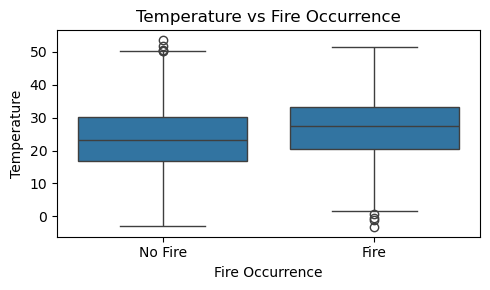

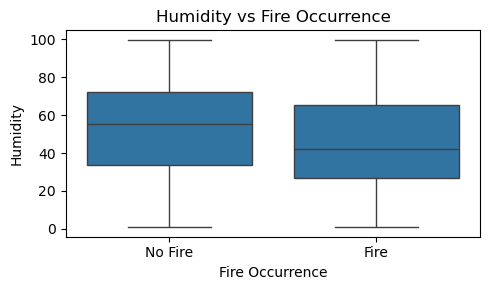

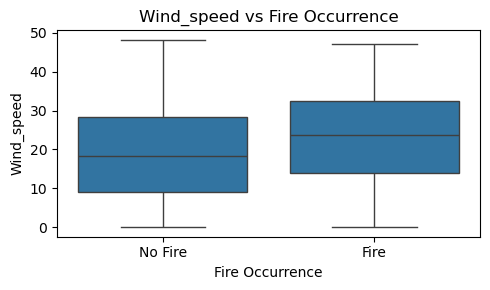

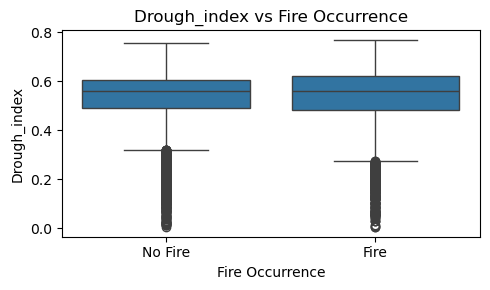

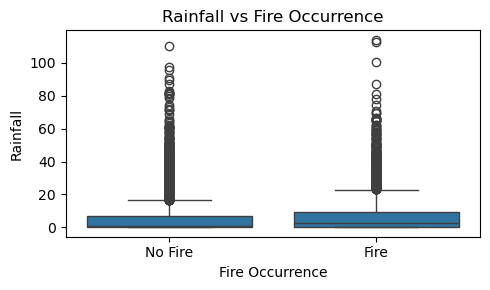

In [19]:
# box plots for continuous variables (temperature, humidity, wind speed, drought index, rainfall))
for col in ['temperature', 'humidity', 'wind_speed', 'drough_index', 'rainfall']:
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=df, x='fire_occurrence', y=col)
    plt.title(f'{col.capitalize()} vs Fire Occurrence')
    plt.xlabel('Fire Occurrence')
    plt.ylabel(col.capitalize())
    plt.xticks([0, 1], ['No Fire', 'Fire'])
    plt.tight_layout()
    plt.show()

### Categorical Variables: Vegetable Type, Region, Previous Fire

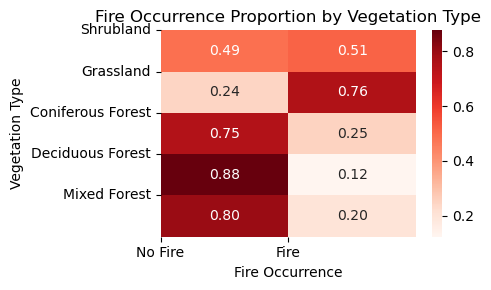

In [20]:
# heatmap for correlation between continuous variables
veg_ct = pd.crosstab(df['vegetation_type'], df['fire_occurrence'], normalize='index')
plt.figure(figsize=(5, 3))
sns.heatmap(veg_ct, annot=True, cmap='Reds', fmt=".2f")
plt.title('Fire Occurrence Proportion by Vegetation Type')
plt.xlabel('Fire Occurrence')
plt.ylabel('Vegetation Type')
plt.xticks([0, 1], ['No Fire', 'Fire'])
plt.yticks(ticks=np.arange(5), labels=['Shrubland', 'Grassland', 'Coniferous Forest', 'Deciduous Forest', 'Mixed Forest'], rotation=0)
plt.tight_layout()
plt.show()

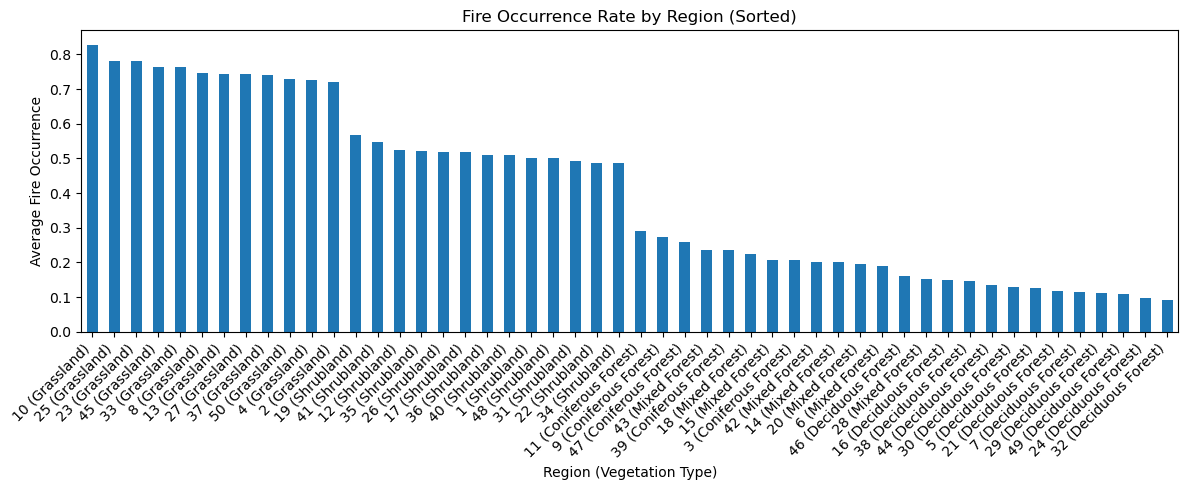

In [21]:
# map vegetation types to regions
veg_labels = {
    0: 'Shrubland',
    1: 'Grassland',
    2: 'Coniferous Forest',
    3: 'Deciduous Forest',
    4: 'Mixed Forest'
}

# get most common vegetation type for each region
region_to_veg = (
    df.groupby('region_id')['vegetation_type']
    .agg(lambda x: x.value_counts().index[0])
    .map(veg_labels)
)

region_fire_rate = df.groupby('region_id')['fire_occurrence'].mean().sort_values(ascending=False)

# plot fire occurrence rate by region
region_fire_rate.plot(kind='bar', figsize=(12, 5))
plt.title('Fire Occurrence Rate by Region (Sorted)')
plt.xlabel('Region (Vegetation Type)')
plt.ylabel('Average Fire Occurrence')
plt.xticks(
    ticks=range(len(region_fire_rate)),
    labels=[f"{int(region)} ({region_to_veg[region]})" for region in region_fire_rate.index],
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.show()

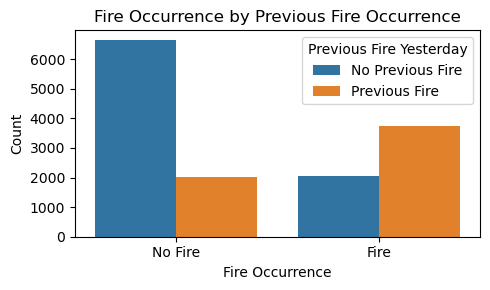

In [22]:
# countplot of fire occurrence by previous fire occurrence
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='fire_occurrence', hue='previous_fire')
plt.title('Fire Occurrence by Previous Fire Occurrence')
plt.xlabel('Fire Occurrence')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Fire', 'Fire'])
plt.legend(title='Previous Fire Yesterday', loc='upper right', labels=['No Previous Fire', 'Previous Fire'])
plt.tight_layout()
plt.show()

**Further Exploration:** 
Should I remove either drought index or humidity?

<Axes: xlabel='humidity', ylabel='drough_index'>

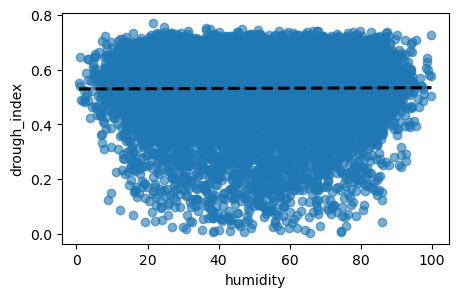

In [23]:
# plot line of best fit for humidity vs drought index
plt.figure(figsize=(5, 3))
sns.regplot(data=df, x='humidity', y='drough_index', 
            scatter_kws={'alpha': 0.6}, line_kws={"color": "black", "linestyle": "--"})

No. Keep both. There is no clear relationship.

### Conclusions
Fires correlated with:
- Higher temperature
- Lower humidity
- Higher wind speed
- Grassland & Shrubland vegetation types
- Previous fire in the region on previous day

Note: Above graphs only provide a rough idea of correlations, but values have not been normalized.

### Cleaned Data

In [24]:
# final display of the dataframe before processing
df.head()

,region_id,temperature,humidity,wind_speed,rainfall,vegetation_type,drough_index,previous_fire,fire_occurrence,fire_season
0,1.0,29.773312,84.710759,4.665236,0.847981,0,0.706012,0.0,0.0,2
1,1.0,19.267481,70.835021,16.753346,2.925033,0,0.667292,0.0,0.0,2
2,1.0,32.894305,75.852071,10.829271,3.858680,0,0.625556,0.0,0.0,2
3,1.0,26.960311,80.894930,13.943569,0.717945,0,0.661796,0.0,1.0,2
4,1.0,27.075079,65.085132,17.118529,1.162567,0,0.684880,1.0,1.0,2


## Logistic Regression

In [25]:
# remove dependent data from independent data
X, y = df.drop('fire_occurrence', axis=1), df['fire_occurrence']

# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# scale the data to ensure all features contribute equally to the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create and train the model
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
predictions = log_model.predict(X_test_scaled)

### Model Evaluation

In [26]:
def evaluate_model(y_test, predictions):
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

    conf_matrix = confusion_matrix(y_test, predictions)
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # raw counts confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'], ax=axes[0])
    axes[0].set_title('Confusion Matrix (Counts)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # percentages confusion matrix
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'], ax=axes[1])
    axes[1].set_title('Confusion Matrix (Percentages)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # classification report
    print(classification_report(y_test, predictions, target_names=['No Fire', 'Fire']))

    from sklearn.metrics import precision_score, recall_score, f1_score

    # Key Fire Metrics
    accuracy = accuracy_score(y_test, predictions)
    fire_precision = precision_score(y_test, predictions, pos_label=1)
    fire_recall = recall_score(y_test, predictions, pos_label=1)
    fire_f1 = f1_score(y_test, predictions, pos_label=1)

    print("\n🔥 FIRE-SPECIFIC PERFORMANCE METRICS:")
    print(f"✅ Accuracy:          {accuracy*100:.1f} – overall correctness of predictions")
    print(f"🚨 Precision (Fire):  {fire_precision*100:.1f}% - predicted fires that were actual fires (false alarm rate = {(1 - fire_precision) * 100:.1f}%)")
    print(f"🔥 Recall (Fire):     {fire_recall*100:.1f}% - actual fires that were correctly identified")
    print(f"⚖️ F1 Score (Fire):   {fire_f1*100:.1f}% – balance between precision and recall")

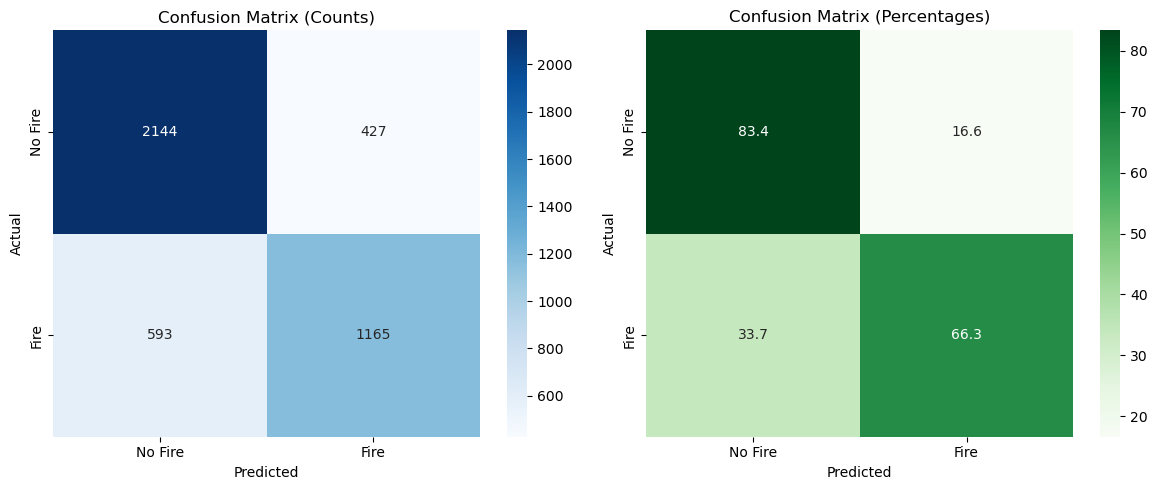

              precision    recall  f1-score   support

     No Fire       0.78      0.83      0.81      2571
        Fire       0.73      0.66      0.70      1758

    accuracy                           0.76      4329
   macro avg       0.76      0.75      0.75      4329
weighted avg       0.76      0.76      0.76      4329


🔥 FIRE-SPECIFIC PERFORMANCE METRICS:
✅ Accuracy:          76.4 – overall correctness of predictions
🚨 Precision (Fire):  73.2% - predicted fires that were actual fires (false alarm rate = 26.8%)
🔥 Recall (Fire):     66.3% - actual fires that were correctly identified
⚖️ F1 Score (Fire):   69.6% – balance between precision and recall


In [27]:
# evaluate the model
evaluate_model(y_test, predictions)

## Decision Tree Classifier

### Data Preprocessing

In [28]:
# create new dataframe for decision tree classifier
dtdf = df.copy()

In [29]:
dtdf.head()

,region_id,temperature,humidity,wind_speed,rainfall,vegetation_type,drough_index,previous_fire,fire_occurrence,fire_season
0,1.0,29.773312,84.710759,4.665236,0.847981,0,0.706012,0.0,0.0,2
1,1.0,19.267481,70.835021,16.753346,2.925033,0,0.667292,0.0,0.0,2
2,1.0,32.894305,75.852071,10.829271,3.858680,0,0.625556,0.0,0.0,2
3,1.0,26.960311,80.894930,13.943569,0.717945,0,0.661796,0.0,1.0,2
4,1.0,27.075079,65.085132,17.118529,1.162567,0,0.684880,1.0,1.0,2


In [30]:
dtdf.describe()

,region_id,temperature,humidity,wind_speed,rainfall,vegetation_type,drough_index,previous_fire,fire_occurrence,fire_season
count,14429.000000,14429.000000,14429.000000,14429.000000,14429.000000,14429.000000,14429.000000,14429.000000,14429.000000,14429.000000
mean,25.506272,24.917174,49.953836,20.592820,6.014309,1.806362,0.531837,0.398434,0.400721,2.497678
std,14.429659,8.930829,22.325963,11.540786,10.160488,1.457868,0.120696,0.489593,0.490062,1.119712
min,1.000000,-3.318065,0.753814,0.000934,0.000000,0.000000,0.003009,0.000000,0.000000,1.000000
25%,13.000000,18.182295,29.972391,10.662619,0.000000,0.000000,0.486349,0.000000,0.000000,1.000000
50%,26.000000,24.959950,49.817595,20.462843,1.596541,2.000000,0.558471,0.000000,0.000000,3.000000
75%,38.000000,31.711025,69.998295,30.381145,7.738454,3.000000,0.608506,1.000000,1.000000,3.000000
max,50.000000,53.672885,99.881290,48.199633,114.091525,4.000000,0.769467,1.000000,1.000000,4.000000


Continuous data might need to be binned...

#### Option 1: bin rainfall and drought index
- Temperature: use raw
- Humidity: use raw
- Wind Speed: use raw
- Rainfall: manual threshold at median - dry / rainy
- Drought index: 4 equal bins

In [31]:
dtdf_binned = dtdf.copy()

# Rainfall: log-transform then quantile-based bins (q=3), due to right-skew
dtdf_binned.loc[:, 'rainfall_bin'] = pd.cut(
    dtdf_binned['rainfall'],
    bins=[-float('inf'), 1.6, float('inf')],
    labels=[0, 1]  # 0 = Dry (≤1.6mm), 1 = Rainy (>1.6mm)
).astype(int)

# Drought Index: equal-width bins based on distribution (0 = Dry, 1 = Moderate, 2 = Moist, 3 = Wet)
dtdf_binned.loc[:, 'drought_bin'] = pd.cut(
    dtdf_binned['drough_index'],
    bins=[-float('inf'), 0.48, 0.56, 0.61, float('inf')],
    labels=[0, 1, 2, 3]  # 0 = Dry, 1 = Moderate, 2 = Moist, 3 = Wet
).astype(int)

# drop original continuous columns after binning
dtdf_binned = dtdf.drop(columns=['rainfall', 'drough_index'])
dtdf_binned.head()

,region_id,temperature,humidity,wind_speed,vegetation_type,previous_fire,fire_occurrence,fire_season
0,1.0,29.773312,84.710759,4.665236,0,0.0,0.0,2
1,1.0,19.267481,70.835021,16.753346,0,0.0,0.0,2
2,1.0,32.894305,75.852071,10.829271,0,0.0,0.0,2
3,1.0,26.960311,80.894930,13.943569,0,0.0,1.0,2
4,1.0,27.075079,65.085132,17.118529,0,1.0,1.0,2


#### Option 2: additionally bin temp, humidity, wind speed
- Temperature: 4 equal-width bins
- Humidity: 4 quartile-based bins
- Wind speed: 4 equal-width bins

In [32]:
dtdf_binned2 = dtdf_binned.copy()

# Temperature: equal-width bins with int labels (0 = Cold, 1 = Mild, 2 = Hot, 3 = Extreme)
dtdf_binned2.loc[:, 'temp_bin'] = pd.cut(
    dtdf_binned2['temperature'],
    bins=[-float('inf'), 15, 25, 35, float('inf')],
    labels=[0, 1, 2, 3]  # 0 = Cold, 1 = Mild, 2 = Hot, 3 = Extreme
).astype(int)

# Humidity: quartile-based bins (q=4), high std (0 = Very Low, 1 = Low, 2 = High, 3 = Very High)
dtdf_binned2.loc[:, 'humidity_bin'] = pd.qcut(
    dtdf_binned2['humidity'],
    q=4,
    labels=[0, 1, 2, 3],  # 0 = Very Low, 1 = Low, 2 = High, 3 = Very High
    duplicates='drop'
).astype(int)

# Wind Speed: equal-width bins with int labels (0 = Calm, 1 = Breezy, 2 = Windy, 3 = Stormy)
dtdf_binned2.loc[:, 'wind_speed_bin'] = pd.cut(
    dtdf_binned2['wind_speed'],
    bins=[-float('inf'), 5, 15, 25, float('inf')],
    labels=[0, 1, 2, 3]  # 0 = Calm, 1 = Breezy, 2 = Windy, 3 = Stormy
).astype(int)

# drop original continuous columns after binning
dtdf_binned2 = dtdf_binned2.drop(columns=['temperature', 'humidity', 'wind_speed'])
dtdf_binned2.head()

,region_id,vegetation_type,previous_fire,fire_occurrence,fire_season,temp_bin,humidity_bin,wind_speed_bin
0,1.0,0,0.0,0.0,2,2,3,0
1,1.0,0,0.0,0.0,2,1,3,2
2,1.0,0,0.0,0.0,2,2,3,1
3,1.0,0,0.0,1.0,2,2,3,1
4,1.0,0,1.0,1.0,2,2,2,2


### Model Training & Evaluation

In [33]:
# uncomment to use the original dataframe or the binned dataframes
X, y = dtdf.drop('fire_occurrence', axis=1), dtdf['fire_occurrence'].values # best performance
# X, y = dtdf_binned.drop('fire_occurrence', axis=1), dtdf_binned['fire_occurrence'].values
# X, y = dtdf_binned2.drop('fire_occurrence', axis=1), dtdf_binned2['fire_occurrence'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

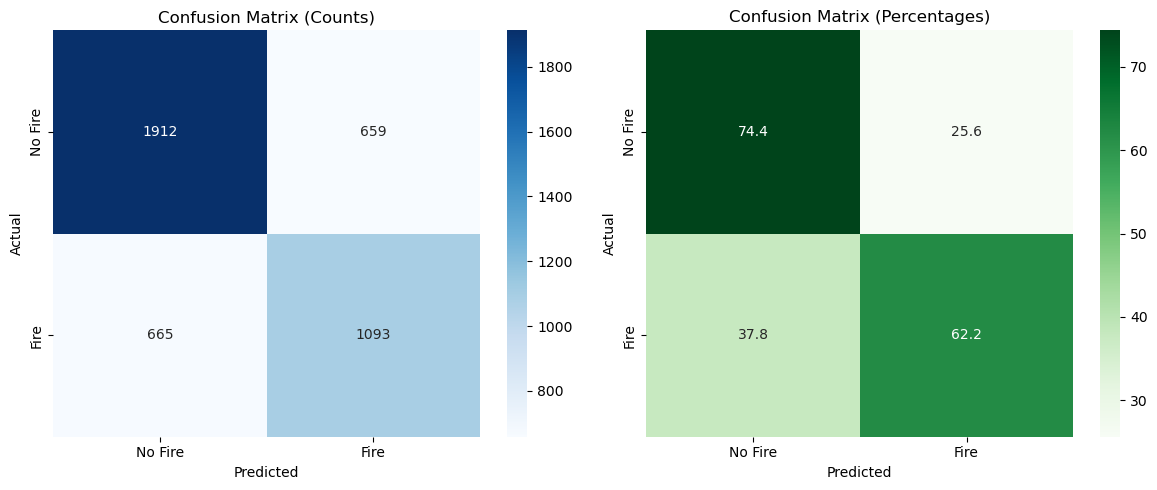

              precision    recall  f1-score   support

     No Fire       0.74      0.74      0.74      2571
        Fire       0.62      0.62      0.62      1758

    accuracy                           0.69      4329
   macro avg       0.68      0.68      0.68      4329
weighted avg       0.69      0.69      0.69      4329


🔥 FIRE-SPECIFIC PERFORMANCE METRICS:
✅ Accuracy:          69.4 – overall correctness of predictions
🚨 Precision (Fire):  62.4% - predicted fires that were actual fires (false alarm rate = 37.6%)
🔥 Recall (Fire):     62.2% - actual fires that were correctly identified
⚖️ F1 Score (Fire):   62.3% – balance between precision and recall


In [34]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

predictions = dtree.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# evaluate the model
evaluate_model(y_test, predictions)

Binned results are worse. Therefore, keeping non-binned df and moving forward with RF algorithms.

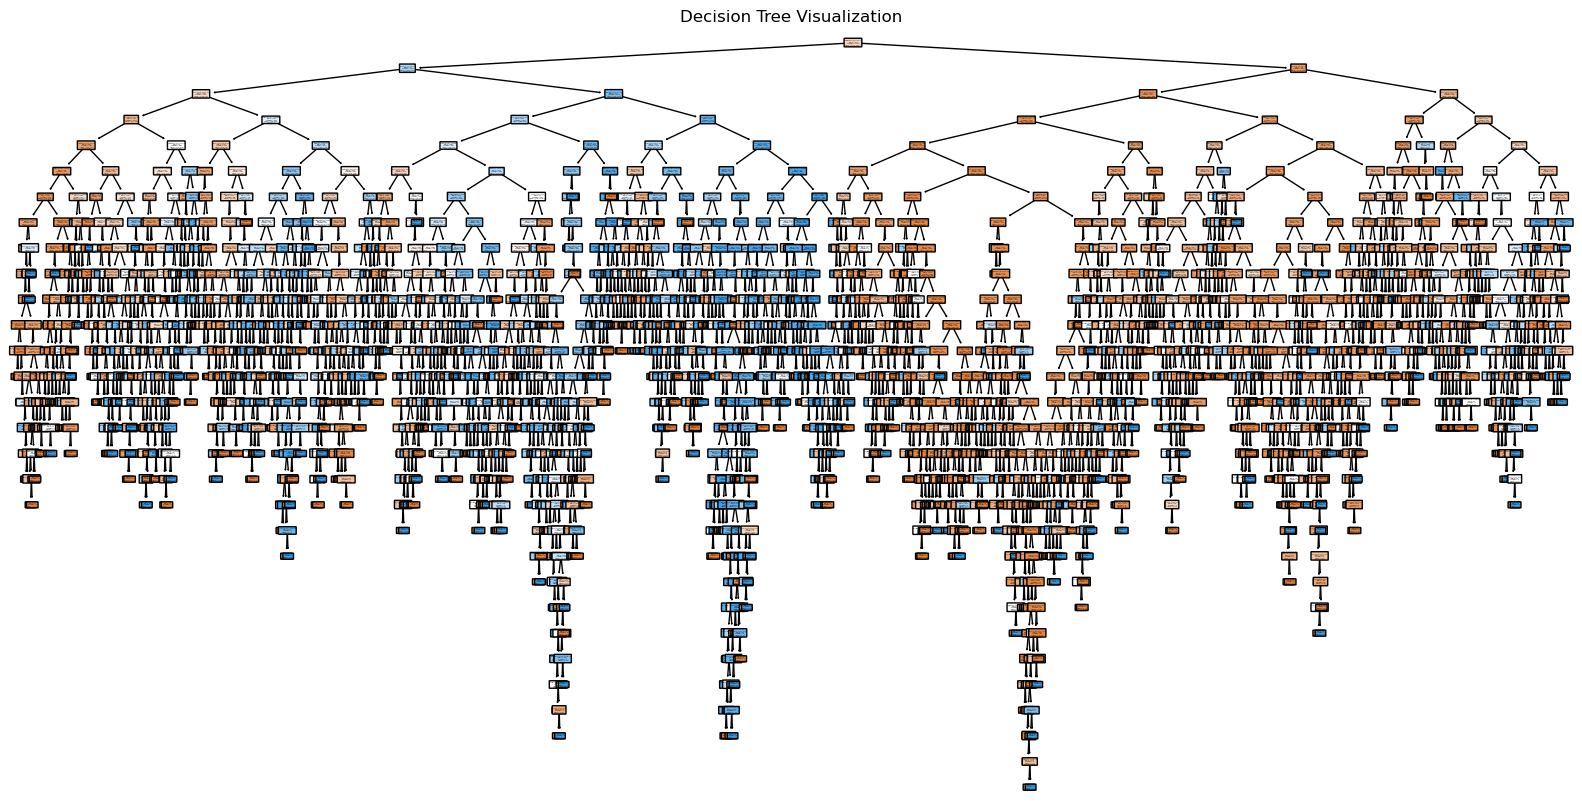

In [35]:
# Visualize the decision tree for top 5 features
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dtree, feature_names=X.columns, class_names=['No Fire', 'Fire'], filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

## Random Forest Classifier
Justification for choosing Random Forest model: Random Forest as it is an improvement of the Decision Tree model by combining predictions of multiple Decision Trees. For our dataset and goal to predict a binary result (fire / no fire), Random Forest is a robust choice with the ability to handle variance and imbalanced data better. In addition, it requires minimal pre-processing.
### Model Training & Evaluation

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

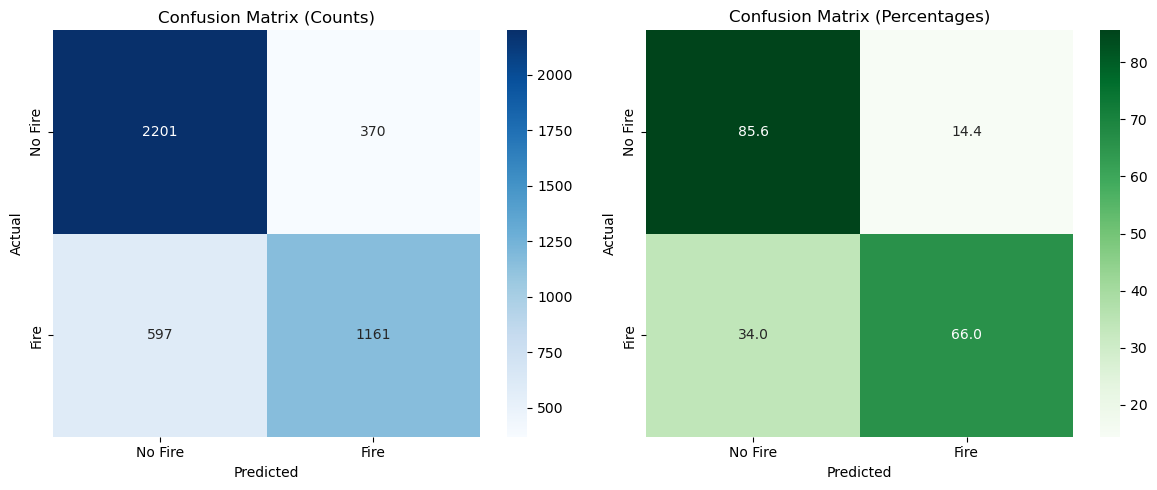

              precision    recall  f1-score   support

     No Fire       0.79      0.86      0.82      2571
        Fire       0.76      0.66      0.71      1758

    accuracy                           0.78      4329
   macro avg       0.77      0.76      0.76      4329
weighted avg       0.78      0.78      0.77      4329


🔥 FIRE-SPECIFIC PERFORMANCE METRICS:
✅ Accuracy:          77.7 – overall correctness of predictions
🚨 Precision (Fire):  75.8% - predicted fires that were actual fires (false alarm rate = 24.2%)
🔥 Recall (Fire):     66.0% - actual fires that were correctly identified
⚖️ F1 Score (Fire):   70.6% – balance between precision and recall


In [51]:
evaluate_model(y_test, rf_predictions)

## Insights and Recommendations

#### Logistic Regression Performance:
- ✅ Accuracy:          76.4 – overall correctness of predictions
- 🚨 Precision (Fire):  73.2% - predicted fires that were actual fires (false alarm rate = 26.8%)
- 🔥 Recall (Fire):     66.3% - actual fires that were correctly identified
- ⚖️ F1 Score (Fire):   69.6% – balance between precision and recall
#### Decision Tree Performance:
- ✅ Accuracy:          69.7 – overall correctness of predictions
- 🚨 Precision (Fire):  62.8% - predicted fires that were actual fires (false alarm rate = 37.2%)
- 🔥 Recall (Fire):     62.3% - actual fires that were correctly identified
- ⚖️ F1 Score (Fire):   62.6% – balance between precision and recall
#### Random Forest Performance:
- ✅ Accuracy:          77-78% – overall correctness of predictions
- 🚨 Precision (Fire):  75-76% - predicted fires that were actual fires (false alarm rate = 24.6%)
- 🔥 Recall (Fire):     ~65% - actual fires that were correctly identified
- ⚖️ F1 Score (Fire):   ~70% – balance between precision and recall
### Analysis
Overall, the Random Forest model performed the best on multiple aspects. While its overall accuracy was similar to the Logistic Regression model, it performs slightly better on precision on predicting fires when there were actually fires and slightly worse on correctly identifying actual fires. Overall, the Random Forest model is the best option considering the trade-off between predicting fires and avoiding false alarms.
<br><br>


### Feature Importance
The top four features in descending order of importance are vegetation type, wind speed, temperature, and humidity. This aligns with fire science, which emphasizes the fire triangle: **fuel, oxygen, and heat**. Vegetation types like shrubs and grass serve as ideal fuel sources, especially when coupled with low humidity. Wind accelerates the spread of fire by supplying oxygen and dispersing embers, while high temperatures can dry out fuels and contribute to ignition conditions.

/var/folders/6f/799xg_3d3tq0bv1l90qmnwt40000gn/T/ipykernel_67687/2034538205.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


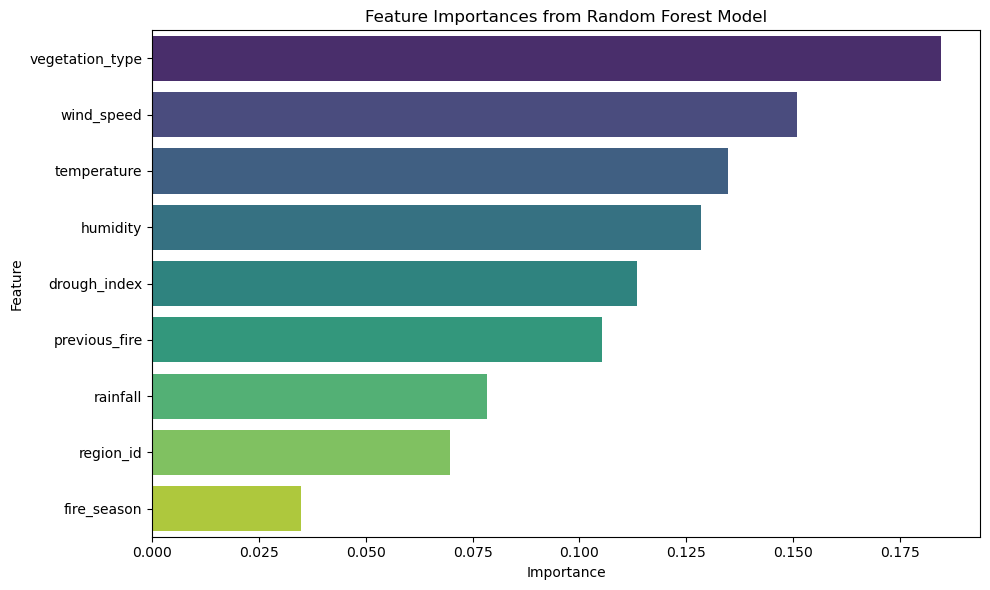

In [38]:
# evaluate feature importance of Random Forest model
importances = rf_model.feature_importances_
feature_names = X.columns
# create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Real-World Application
These insights can serve as a valuable guide for forest fire risk mitigation. Regions that exhibit high-risk characteristics—such as certain vegetation types, low humidity, and high wind speeds—can be prioritized for early warning systems, preventative interventions, and targeted resource allocation. By monitoring the values of key variables, organizations responsible for fire management can more accurately identify days and regions at higher risk of fire, enabling a shift from reactive response to proactive prevention.

## REST API

In [39]:
import joblib
joblib.dump(rf_model, 'fire_model.pkl')


['fire_model.pkl']

In [40]:
from flask import Flask, request, jsonify
app = Flask(__name__)

# import pkl file
model = joblib.load('./fire_model.pkl')

# create post request
@app.route('/test', methods=['POST'])
def test():
  if request.is_json:
    record = request.get_json()
    df = pd.DataFrame([record])
    result = model.predict(df)
    return jsonify({'result': result.tolist()})
  else:
    return jsonify({'error': 'Request must be JSON'}), 400

#### Starting the server:

In [ ]:
if __name__ == '__main__':
  app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


#### Testing the server:
1. Send POST request to http://127.0.0.1:5000/test as JSON data in this format:
Example:<br>
```
{
  "region_id": 1.0,
  "temperature": 27.5,
  "humidity": 58.0,
  "wind_speed": 6.4,
  "rainfall": 0.8,
  "vegetation_type": 0,
  "drough_index": 0.67,
  "previous_fire": 1.0,
  "fire_season": 2
}
```
#### Valid values:
- region_id: int 1 to 50 (unique region id)
- temperature: double -3 to 53 (degrees in C)
- humidity: double 0 to 100 (percentage)
- wind speed: double 0 to 48 (km/s)
- rainfall: double 0 to 114 (mm)
- vegetation type: int 1 to 4 (    'Shrubland': 0,
    'Grassland': 1,
    'Coniferous Forest': 2,
    'Deciduous Forest': 3,
    'Mixed Forest': 4)
- drought index: double 0 to 1
- previous fire: int 0 or 1 ('No Fire': 0, 'Fire': 1)
- fire season: int 1-4 ('Oct, Nov, Dec': 1, 'Jan, Feb, Sep': 2, 'Mar, Jul, Aug': 3, 'Apr, May, Jun': 4)

### Testing platforms:
- Postman desktop agent
- curl from terminal
```
curl -X POST http://127.0.0.1:5000/test \
-H "Content-Type: application/json" \
-d '{
  "region_id": 1.0,
  "temperature": 27.5,
  "humidity": 58.0,
  "wind_speed": 6.4,
  "rainfall": 0.8,
  "vegetation_type": 0,
  "drough_index": 0.67,
  "previous_fire": 1.0,
  "fire_season": 2
}'
```
